# Milestone Project 1: Food Vision Big
In this notebook we're going to be building a Food vision model that can beat the original results of the [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment), a 2016 paper which used a CNN trained for 2-3 days to achieve 77.4% top-1 accuracy.

Alongside attempting to beat the DeepFood paper, we're going to implement  two methods to significantly improve the speed of our model training:

  1. Prefetching
  2. Mixed precision training

## Get Helper Functions
We'll import some `helper_functions.py`, that can help us across the experimentations.



In [1]:
# Dowloead helper functions scripts
!wget https://raw.githubusercontent.com/Charliecr94/Tensor_flow_projects/main/Extras/helper_functions.py

--2023-02-24 21:30:16--  https://raw.githubusercontent.com/Charliecr94/Tensor_flow_projects/main/Extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10234 (10.0K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]   9.99K  --.-KB/s    in 0s      

2023-02-24 21:30:16 (60.8 MB/s) - ‘helper_functions.py.1’ saved [10234/10234]



In [2]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Dataset to Download Data

In [3]:
# Get TensorFlow Datasets
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [4]:
tf.__version__, np.__version__

('2.11.0', '1.22.4')

In [5]:
# Load in the data.
(train_data, test_data), ds_info = tfds.load(name="food101",
                                            split=["train","validation"],
                                            shuffle_files= True,
                                            as_supervised= True,
                                            with_info = True)

In [6]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

We've now got access to entire Food101 dataset (in tensor format) ready for modeling.

Now let's get a little information from our datasets, starting with the class names.

In [7]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Exploring the Food101 data from TensorFlow Datasets

To become one with our data, we want to find:
  * The shape of our input data (image tensors)
  * The datatype of our input data
  * What the labels look like
  * Do the labels match up with the class_names

To do so, let's take one sample off the training data (using the `.take()` method) and explore it.

In [8]:
# Take one sample of the train data
train_one_sample = train_data.take(1)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [9]:
# Output info abour our training sample
for image, label in train_one_sample:
  print(f"""
   Image shape: {image.shape}
   Image datatype: {image.dtype}
   Target Class From Food101: {label}
   Class name (str form): {class_names[label.numpy()]}
  """)


   Image shape: (512, 512, 3)
   Image datatype: <dtype: 'uint8'>
   Target Class From Food101: 1
   Class name (str form): baby_back_ribs
  


## Plot an  image from TensorFlow Datasets.

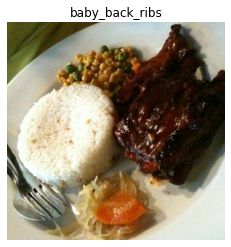

In [10]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create preprocessing functions for our data

In order to get the data ready for a neural network, we'll had to write preprocessing functions and map it to the data.

What we know about our data:

  * In `uint8` datatype
  * Comprised of all different size tensors (different sized images)
  * Not scaled (the pixel values are between 0 & 255)

What we know models like:
  
  * Data in float32 dtype.
  * For Batches, tensorflow likes all of the tensoers within a batch to be of the same size.
  * Scaled (vlues between 0 & 1) also called normalized tensors generally perform better.

With these points in mind, we've got a few things we can tackle with a preprocessing function. This functions needs to:
  1. Reshape our images to all the same size
  2. Convert the dtype of our image tensors from `unit8` to `float32`


In [11]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

Let's try our function out on a target image.

In [12]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 95  95  25]
  [ 87  87  17]
  [ 96  93  26]
  ...
  [178 189 191]
  [180 191 193]
  [178 189 191]]

 [[ 92  92  22]
  [ 86  86  16]
  [ 91  88  21]
  ...
  [183 194 196]
  [184 195 197]
  [180 191 193]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 88.755104  88.755104  18.755102]
  [ 88.341835  85.341835  18.341835]
  [ 86.377556  81.16327   17.591837]
  ...
  [182.5153   193.5153   195.5153  ]
  [181.47958  192.47958  194.47958 ]
  [181.39784  192.39784  194.39784 ]]

 [[ 96.57143   93.57143   24.571428]
  [ 92.38265   89.38265   22.382656]
  [ 93.72959   88.515305  24.94388 ]
  ...
  [189.42863  200.42863  202.42863 ]
  [189.78568  200.78568  202.78568 ]
  [183.90295  197.90295  198.90295 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


Excellent! Looks like our `preprocess_img()` function is working as expected. Becuase the input image gets converted from `uint8` to `float32` and also get reshaped from its current shape to `(224,224,3)`

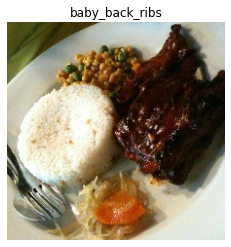

In [13]:
# We can still plot our preprocessed image as long as we divide by 255 (for matplotlib capatibility))
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

# Batch & prepare datasets.

Before we can model our data, we have to turn it into batches, that way our computing memory will be efficient, so we're going to be leveraging a number of methods from the `tf.data` [API](https://www.tensorflow.org/api_docs/python/tf/data)

More specifically, we're going to be using:
  * `map() `- maps a predefined function to a target dataset.
  *` shuffle()` - randomly shuffles the elements of a target dataset up 
`buffer_size`. 
  * `batch()` - Turns elemenents of a target dataset into batches
  * `prefetch()` - Prepares subsequent batches of data whilist other batches of data are being computed on.
  * `cache()` - Caches elements in a target dataset, saving loading time.




In [14]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

In [15]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (Load i faster).
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

And now let's check out what our prepared datasets look like.

In [16]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks

Since we're going the be training on a large amount of data and training could take a long time, is a good idea to set up some modelling callbacks.

To do each we'll use the following callbacks:
  * ` tf.keras.callbacks.TensorBoard()` - allows us to kkep tack our model's training history so we can inspect it later.
  * ` tf.keras.callbacks.ModelCheckpoint()` saves our model's progress at various intervals so we can load it and reuses it later withour having to retrain it.

In [17]:
# Create TensorBoard callback
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights, requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor= "val_accuracy",
                                                      save_best_only= True,
                                                      save_weights_only= True,
                                                      verbose=0)


## Setup Mixed precision training.
For speed up the performance of our model, let's set up Mixed precision, which is a method that utilized a combination of float32 and float16 data types to speed up model performance. 

According to his documentation, this API can improve perfomance by more thean 3 times on modern GPUS and 60% on TPUS.




In [18]:
 # Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision

In [19]:
mixed_precision.global_policy()

<Policy "mixed_float16">

# Build Feature extraction model

Now that or Callbacks are ready to roll and the mixed precision is ON, we are ready to build our firts model.

In [20]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [21]:
# Check out our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## Checking layer dtype policies (are we using mixed precision?)

In [22]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [23]:
# Check the dtype_policy attributes of layers in the base model
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <

Alrigth! sees like the mixed precision API automatically change our layers `dtype policy's` to whatever the global dtype policy is.


### Fit the feature extraction model.

Due to our final goal is to  fine-tune a pretrained model, the general order of doing things is:
  1. Buila a feauture extracion model (Just training a couple of output layers with base layers frozen)
  2. Fine-tune some of the frozen layers.

In [24]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fith the feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230224-213042
Epoch 1/3
2368/2368 [==============================] - 201s 78ms/step - loss: 1.7166 - accuracy: 0.5812 - val_loss: 1.1246 - val_accuracy: 0.6994
Epoch 2/3
2368/2368 [==============================] - 181s 75ms/step - loss: 1.1990 - accuracy: 0.6893 - val_loss: 1.0161 - val_accuracy: 0.7264
Epoch 3/3
2368/2368 [==============================] - 180s 75ms/step - loss: 1.0538 - accuracy: 0.7246 - val_loss: 0.9962 - val_accuracy: 0.7259


In [25]:
results_feature_extract_model = model.evaluate(test_data)

790/790 [==============================] - 53s 67ms/step - loss: 1.0042 - accuracy: 0.7257


## Save the whole model to file (In google drive)

In [ ]:
# Create Save path to drive
save_dir = "/content/drive/MyDrive/Food_vision_model/efficientnetb0_feature_extract_model_mixed_precision/"

# Save model
model.save(save_dir)

In [ ]:
# Load model previously saved above
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [ ]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

In [ ]:
# Check if the loaded model's results are equals to the saved models results.
import numpy as np
assert np.isclose(results_feature_extract_model, results_loaded_saved_model).all()

#  Preparing our model's layers for fine-tuning.

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [28]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 True
1 rescaling True
2 normalization True
3 rescaling_1 True
4 stem_conv_pad True
5 stem_conv True
6 stem_bn True
7 stem_activation True
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block2a_expand_conv True
19 block2a_expand_bn True
20 block2a_expand_activation True
21 block2a_dwconv_pad True
22 block2a_dwconv True
23 block2a_bn True
24 block2a_activation True
25 block2a_se_squeeze True
26 block2a_se_reshape True
27 block2a_se_reduce True
28 block2a_se_expand True
29 block2a_se_excite True
30 block2a_project_conv True
31 block2a_project_bn True
32 block2b_expand_conv True
33 block2b_expand_bn True
34 block2b_expand_activation True
35 block2b_dwconv True
36 block2b_bn True
37 block2b_activation True
38 block2b_se_squeeze True
39 block2b_se_reshape True
40 block2b_se_

Wonderful, it looks like each layer in our base model is trainable, now let's check if every layer which should be using the dtaype policy `"mixed_policy"` is using it.

In [29]:
# Check the dtype_policy of the layers in our model.
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


See's like everything is ready for compile our fine-tune model, but firts let's set a `EarlyStopping callback`, a `ModelCheckpoint` and a `learning rate` reduction callback.



In [30]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3)

# Create Model Checkpoint callback to save best model during fine-tuning
checkpoint_path = "model_fine_tuning_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor= "val_accuracy",
                                                      save_weights_only= True,
                                                      save_best_only= True)

# Creating learning rate reduction callbacks.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor= "val_loss",
                                                 factor = 0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

Now we've got to recompile our model

In [33]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer= tf.keras.optimizers.Adam(0.0001),
              metrics=["accuracy"])


## Fine-tuning
Let's fit the model on all  our data, we'll set it up to run for up to 100 epochs, but since we're going to be using the EarlyStopping callback, it might stop before reaching 100 epochs.



In [34]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Strat to fine-tune
history_101_food_class_all_data_fine_tuning = model.fit(train_data,
                                                        epochs= 100,
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps= int(0.15*len(test_data)),
                                                        callbacks=[create_tensorboard_callback("training_logs",
                                                                                               "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                   model_checkpoint,
                                                                   early_stopping,
                                                                   reduce_lr])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230224-215020
Epoch 1/100
2368/2368 [==============================] - 414s 158ms/step - loss: 0.8169 - accuracy: 0.7787 - val_loss: 0.7373 - val_accuracy: 0.7942 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 370s 155ms/step - loss: 0.5053 - accuracy: 0.8582 - val_loss: 0.7780 - val_accuracy: 0.7860 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.2795 - accuracy: 0.9197
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 372s 156ms/step - loss: 0.2795 - accuracy: 0.9197 - val_loss: 0.8934 - val_accuracy: 0.7842 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 369s 155ms/step - loss: 0.0664 - accuracy: 0.9840 - val_loss: 0.9148 - val_accuracy: 0.8059 - lr: 2.0000e-05


In [35]:
# Evaluate mixed precision trained fine-tuned model.
results_fine_tuning_model = model.evaluate(test_data)
results_fine_tuning_model

790/790 [==============================] - 52s 65ms/step - loss: 0.9516 - accuracy: 0.8015


[0.9515812397003174, 0.8015049695968628]

Excellent, the main goal is complete! Our model performance accuracy is more than **5.00%** above of the "DeepFood paper". 🎉🎉

Also the training time is less, our model took ~20 minutes to train versus DeepFood's quoted 2-3 days.



## View training results on TensorBoard.

In [ ]:
# Upload experiment results to TensorBoard (uncomment to run)
!tensorboard dev upload --logdir ./training_logs \
--name "Fine-tuning EfficientNetB0 on all Food101 Data" \
--description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \
--one_sh

Viewing our monen at TensorBoard, it looks like our fine-tuning model gains boost in performance but starts to overfit as training goes on.
